In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

In [2]:
imdb = keras.datasets.imdb
vocab_size = 10000
index_from = 3

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=vocab_size, index_from=index_from)

In [3]:
print(train_data[0], train_labels[0])
print(train_data.shape, train_labels.shape)
print(len(train_data[0]), len(train_data[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 1
(25000,) (25000,)
218 189


In [4]:
print(test_data.shape, test_labels.shape)

(25000,) (25000,)


In [5]:
word_index = imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
print(len(word_index))
# print(word_index)

88584


In [6]:
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2
word_index['<END>'] = 3

reverse_word_index = dict([(value, key) for key, value in word_index.items()])

def decode_review(text_ids):
    return ' '.join([reverse_word_index.get(word_id, "<UNK>") for word_id in text_ids])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [7]:
max_length = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, value=word_index['<PAD>'], padding='post', maxlen=max_length)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, value=word_index['<PAD>'], padding='post', maxlen=max_length)

print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [8]:
embedding_dim = 16
batch_size = 128

model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 161,153
Trainable params: 161,153
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time
history = model.fit(train_data, train_labels, epochs=30, batch_size=batch_size, validation_split=0.2)

Epoch 1/30
157/157 [==============================] - 1s 6ms/step - loss: 0.6840 - accuracy: 0.6037 - val_loss: 0.6513 - val_accuracy: 0.7620
Epoch 2/30
157/157 [==============================] - 1s 6ms/step - loss: 0.5505 - accuracy: 0.7952 - val_loss: 0.4493 - val_accuracy: 0.8338
Epoch 3/30
157/157 [==============================] - 1s 6ms/step - loss: 0.3643 - accuracy: 0.8730 - val_loss: 0.3432 - val_accuracy: 0.8706
Epoch 4/30
157/157 [==============================] - 1s 6ms/step - loss: 0.2834 - accuracy: 0.8962 - val_loss: 0.3088 - val_accuracy: 0.8796
Epoch 5/30
157/157 [==============================] - 1s 6ms/step - loss: 0.2418 - accuracy: 0.9105 - val_loss: 0.2908 - val_accuracy: 0.8880
Epoch 6/30
157/157 [==============================] - 1s 6ms/step - loss: 0.2132 - accuracy: 0.9236 - val_loss: 0.2827 - val_accuracy: 0.8920
Epoch 7/30
157/157 [==============================] - 1s 6ms/step - loss: 0.1907 - accuracy: 0.9313 - val_loss: 0.2792 - val_accuracy: 0.8934
Epoch 

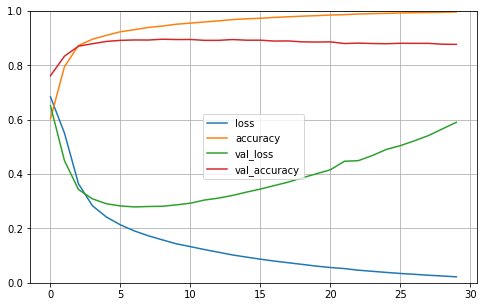

In [10]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)  

In [11]:
model.evaluate(test_data, test_labels, batch_size=batch_size)

196/196 [==============================] - 0s 1ms/step - loss: 0.6381 - accuracy: 0.8604


[0.6381376385688782, 0.8603600263595581]